# คำชี้แจง
ในสัปดาห์นี้ เราจะฝึกใช้ library numpy, pandas, scipy, matplotlib ในการศึกษา pattern ของข้อมูลและทำการทดสอบทางสถิติกัน

และจะมีการแนะนำถึง library seaborn และ statsmodels ซึ่งจะช่วยให้เราวาดกราฟและทำการทดสอบทางสถิติที่ซับซ้อนได้ง่ายขึ้นด้วย

In [7]:
import scipy.stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## ทำการเชื่อมต่อกับ Google Drive ส่วนตัวเพื่อเข้าถึงไฟล์
ถ้าใครที่ไม่ได้วางไฟล์ข้อมูลไว้บน Google Drive ภายใต้ folder Dataset ก็จะต้องแก้ path ข้างล่างด้วย

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ข้อมูลความแข็งแรงของคอนกรีต
ผมวางไฟล์ข้อมูลไว้บน Drive ส่วนตัวที่ folder **Datasets** ถ้าหากว่าวางไฟล์ไว้ที่อื่นก็ต้องเปลี่ยน path ในคำสั่ง **read_csv** ข้างล่างตามด้วย

In [64]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/ConcreteStrength.csv', index_col = None, header = 0)
data.columns = [c.split('(')[0].strip() for c in data.columns] ## clean up column names
data.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete compressive strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


## ตรวจสอบการกระจายตัวของค่าของตัวแปร
ใช้คำสั่ง **normaltest** ใน scipy.stats เพื่อทดสอบว่าค่าการกระจายตัวเป็นไปตาม normal distribution หรือไม่

### ตัวแปร Compressive strength

In [10]:
print(scipy.stats.normaltest(data['Concrete compressive strength']))

NormaltestResult(statistic=33.64775006912804, pvalue=4.937236241653123e-08)


เปรียบเทียบข้อมูลที่เห็นกับค่าการกระจายตัวทางทฤษฎีของ normal distribution

ใช้คำสั่ง **norm.fit** เพื่อคำนวณค่า mean และ SD จากข้อมูล และใช้คำสั่ง **norm.pdf** เพื่อคำนวณค่าการกระจายตัวทางทฤษฎี

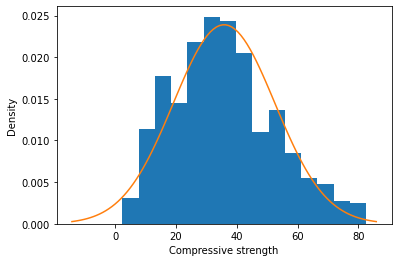

In [11]:
mean, std = scipy.stats.norm.fit(data['Concrete compressive strength'])

plt.figure()
plt.hist(data['Concrete compressive strength'], bins = 15, density = True, label = 'Observed')

x = np.linspace(mean - 3 * std, mean +  3 * std, 100)
plt.plot(x, scipy.stats.norm.pdf(x, mean, std), label = 'Fitted')

plt.xlabel('Compressive strength'); plt.ylabel('Density')
plt.show()

### ตัวแปร Age
ทดลองแปลงข้อมูลด้วย logarithm ผลการใช้ **normaltest** ต่างกันอย่างไร

In [65]:
print(scipy.stats.normaltest(data['Age']))
print(scipy.stats.normaltest(np.log(data['Age'])))

NormaltestResult(statistic=727.478896123572, pvalue=1.0714325997785868e-158)
NormaltestResult(statistic=11.646329703785783, pvalue=0.002958227960547812)


แสดงผล histogram เพื่อเปรียบเทียบก่อนและหลัง log-transform

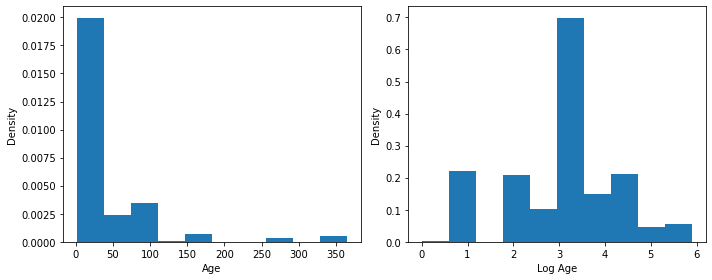

In [13]:
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.hist(data['Age'], density = True)
plt.xlabel('Age'); plt.ylabel('Density')

plt.subplot(1, 2, 2)
plt.hist(np.log(data['Age']), density = True)
plt.xlabel('Log Age'); plt.ylabel('Density')

plt.tight_layout()
plt.show()

เปรียบเทียบข้อมูลที่เห็นกับค่าการกระจายตัวทางทฤษฎีของ normal distribution

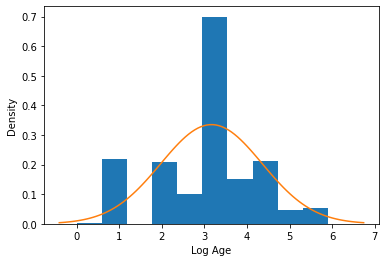

In [14]:
log_age = np.log(data['Age'])
mean, std = scipy.stats.norm.fit(log_age)

plt.figure()
plt.hist(log_age, density = True, label = 'Observed')

x = np.linspace(mean - 3 * std, mean +  3 * std, 100)
plt.plot(x, scipy.stats.norm.pdf(x, mean, std), label = 'Fitted')

plt.xlabel('Log Age'); plt.ylabel('Density')
plt.show()

## ศึกษาความสัมพันธ์ระหว่างตัวแปรส่วนผสมปูนกับความแข็งแรง
เริ่มต้นด้วยการแสดง scatter plot เปรียบเทียบ

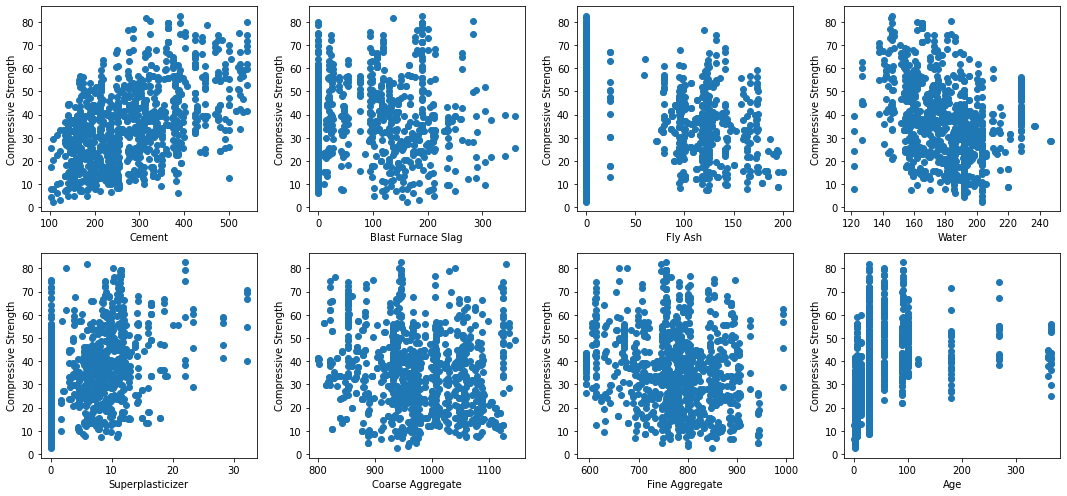

In [16]:
plt.figure(figsize = (15, 7))

for i in range(data.shape[1] - 1):
    plt.subplot(2, 4, i + 1)
    plt.scatter(data.iloc[:, i], data['Concrete compressive strength'])
    plt.xlabel(data.columns[i]); plt.ylabel('Compressive Strength')

plt.tight_layout()
plt.show()

### เจาะลึกที่ตัวแปรส่วนผสม cement
แบ่งข้อมูลเป็นสองกลุ่มตามค่าส่วนผสม cement >200 kg/m$^3$ กับ $\leq$200 kg/m$^3$

In [66]:
high_cement = data.loc[data['Cement'] > 200, 'Concrete compressive strength']
low_cement = data.loc[data['Cement'] <= 200, 'Concrete compressive strength']

เปรียบเทียบความแข็งแรงระหว่างข้อมูลสองกลุ่มด้วย **box plot**

In [ ]:
plt.figure()
plt.boxplot([high_cement, low_cement], labels = ['Cement > 200', 'Cement <= 200'])
plt.ylabel('Compressive strength')
plt.show()

เปรียบเทียบความแข็งแรงระหว่างข้อมูลสองกลุ่มด้วย **histogram**

In [ ]:
plt.figure()
plt.hist([high_cement, low_cement], bins = 15, density = True)
plt.xlabel('Compressive strength'); plt.ylabel('Data density')
plt.legend(['Cement > 200', 'Cement <= 200'])
plt.show()

### ใช้ t-test เพื่อทดสอบว่าความแข็งแรงของข้อมูลสองกลุ่มแตกต่างกันหรือไม่
ทำแบบ two-sided test กับแบบ one-sided test แตกต่างกันอย่างไร

In [18]:
print('t-test')
print(scipy.stats.ttest_ind(high_cement, low_cement, equal_var = False, alternative = 'two-sided'))
print(scipy.stats.ttest_ind(high_cement, low_cement, equal_var = False, alternative = 'greater'))

t-test
Ttest_indResult(statistic=13.073104130277816, pvalue=5.563624021583685e-35)
Ttest_indResult(statistic=13.073104130277816, pvalue=2.7818120107918425e-35)


## คำนวณหา correlation ระหว่างส่วนผสมต่าง ๆ กับค่าความแข็งแรง
ใช้ **pearsonr** ใน scipy.stats

In [19]:
cement_corr = scipy.stats.pearsonr(data['Concrete compressive strength'], data['Cement'])[0]
print(scipy.stats.pearsonr(data['Concrete compressive strength'], data['Cement']))

(0.4978319193241573, 1.3241833072266299e-65)


### ใช้ permutation test เพื่อทดสอบความมีนัยสำคัญทางสถิติของค่า correlation
ขั้นแรกต้องสามารถสลับข้อมูลมั่ว ๆ ได้ก่อน ด้วยคำสั่ง **random.permutation** จาก numpy

In [20]:
np.random.seed(4649)

for n in range(5):
    print(np.random.permutation(5))

[0 1 4 3 2]
[0 4 2 3 1]
[2 3 0 4 1]
[2 4 3 0 1]
[3 2 4 1 0]


ลองคำนวณค่า correlation ระหว่างส่วนผสม cement ที่สลับมั่ว ๆ แล้ว กับค่าความแข็งแรง

In [21]:
shuffled_cement = data['Cement'].iloc[np.random.permutation(data.shape[0])]
print(scipy.stats.pearsonr(data['Concrete compressive strength'], shuffled_cement))

(0.02763001169015095, 0.3757041443999795)


### สลับค่าส่วนผสม cement 1000 ครั้งเพื่อเก็บสถิติการกระจายตัวของค่า correlation
คำสั่ง **random.seed** ใน numpy จะช่วยให้การสลับแต่ละครั้งได้ผลเหมือนเดิม

In [22]:
np.random.seed(4649)
n_run = 1000
shuffled_corr = np.zeros([n_run, ])

for i in range(n_run):
    shuffled_cement = data['Cement'].iloc[np.random.permutation(data.shape[0])]
    shuffled_corr[i] = scipy.stats.pearsonr(data['Concrete compressive strength'], shuffled_cement)[0]

แสดงผลด้วย histogram เปรียบเทียบกับค่าที่ได้จริง

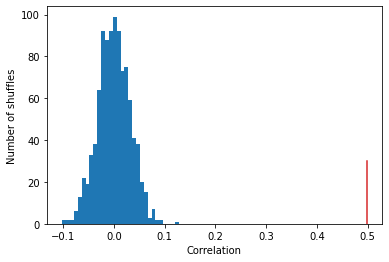

In [23]:
plt.figure();
plt.hist(shuffled_corr, bins = 30);
plt.plot([cement_corr, cement_corr], [0, 30], 'tab:red')
plt.xlabel('Correlation'); plt.ylabel('Number of shuffles')
plt.show()

## ทำความรู้จักค่า correlation แบบอื่น ๆ
* [Spearman's rank correlation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html) สนใจลำดับแทนค่าจริง ถ้าตัวแปรสองตัวทำให้ข้อมูลถูกเรียงลำดับเหมือนกันก็ถือว่าตัวแปรสองตัวนี้ correlate กัน
* [Kendall's tau](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html) สนใจว่าเมื่อหยิบข้อมูลใด ๆ มาสองจุด แล้วเรียงลำดับด้วยตัวแปรสองตัว จะได้ลำดับมากน้อยที่สอดคล้องกันหรือไม่

ลองคำนวณ correlation ทั้งสองค่าแล้วเปรียบเทียบกับ Pearson's correlation

In [67]:
print(scipy.stats.pearsonr(data['Concrete compressive strength'], data['Cement']))
print(scipy.stats.spearmanr(data['Concrete compressive strength'], data['Cement']))
print(scipy.stats.kendalltau(data['Concrete compressive strength'], data['Cement']))

(0.4978319193241573, 1.3241833072266299e-65)
SpearmanrResult(correlation=0.4776143065003231, pvalue=8.265313080448207e-60)
KendalltauResult(correlation=0.3272368700349914, pvalue=2.0332220019448656e-55)


## ทดสอบความแตกต่างของค่าตัวแปร
เริ่มจากข้อมูลคะแนนพื้นที่ใต้กราฟของโมเดลสองตัว บนข้อมูล 7 ชุด พื้นที่ใต้กราฟสูงแปลว่าโมเดลทำงานได้ดีกว่า

In [25]:
auc_df = pd.DataFrame([[0.701, 0.503, 0.991, 0.827, 0.623, 0.728, 0.596], 
                       [0.691, 0.478, 0.905, 0.739, 0.589, 0.719, 0.508]],
                      index = ['Model A', 'Model B'], columns = ['Dataset ' + str(i) for i in range(1, 8)])
auc_df.head()

,Dataset 1,Dataset 2,Dataset 3,Dataset 4,Dataset 5,Dataset 6,Dataset 7
Model A,0.701,0.503,0.991,0.827,0.623,0.728,0.596
Model B,0.691,0.478,0.905,0.739,0.589,0.719,0.508


### เปรียบเทียบความแตกต่างด้วยกราฟ
ใช้ **boxplot**

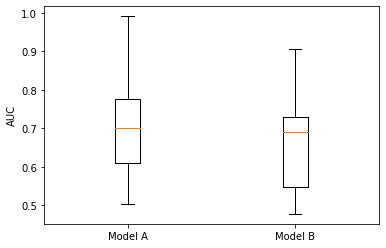

In [26]:
plt.figure()
plt.boxplot([auc_df.loc[index, :] for index in auc_df.index], labels = auc_df.index)
plt.ylabel('AUC')
plt.show()

การใช้ **scatter** ให้มุมมองที่แตกต่างจาก **boxplot** อย่างไร

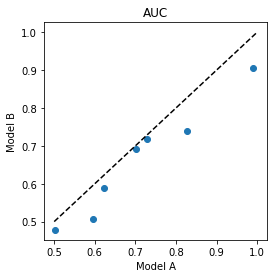

In [27]:
plt.figure(figsize = (4, 4))
plt.scatter(auc_df.loc['Model A', :], auc_df.loc['Model B', :])
plt.xlabel('Model A'); plt.ylabel('Model B'); plt.title('AUC')
plt.plot([0.5, 1], [0.5, 1], '--k')
plt.show()

### เปรียบเทียบการทดสอบด้วย t-tests กับ non-parametric tests
Mann-Whitney U test (**mannwhitneyu**) กับ Wilcoxon signed rank test (**wilcoxon**) ใน scipy.stats คือ unpaired และ paired test แบบ non-parametric 

In [28]:
print('unpaired t-test:', scipy.stats.ttest_ind(auc_df.loc['Model A', :], auc_df.loc['Model B', :]))
print('paired t-test:', scipy.stats.ttest_rel(auc_df.loc['Model A', :], auc_df.loc['Model B', :]))

print('Mann-Whitney U test:', scipy.stats.mannwhitneyu(auc_df.loc['Model A', :], auc_df.loc['Model B', :]))
print('Wilcoxon signed rank test:', scipy.stats.wilcoxon(auc_df.loc['Model A', :], auc_df.loc['Model B', :]))

unpaired t-test: Ttest_indResult(statistic=0.5861139805745107, pvalue=0.5686597321571196)
paired t-test: Ttest_relResult(statistic=3.4485643789623377, pvalue=0.013656963060721596)
Mann-Whitney U test: MannwhitneyuResult(statistic=29.0, pvalue=0.6200466200466201)
Wilcoxon signed rank test: WilcoxonResult(statistic=0.0, pvalue=0.015625)


# ข้อมูลผลการสอบของเด็กนักเรียน
สำหรับข้อมูลชุดนี้ เราจะฝึกวิเคราะห์ตัวแปรชนิด categorical กัน

In [68]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/StudentsPerformance.csv', index_col = None, header = 0)
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


## นับจำนวนข้อมูลที่มาจากแต่ละ category
ด้วย **value_counts**

In [31]:
data['parental level of education'].value_counts()

some college          226
associate's degree    222
high school           196
some high school      179
bachelor's degree     118
master's degree        59
Name: parental level of education, dtype: int64

ด้วย **crosstab**

In [32]:
race_vs_parent = pd.crosstab(data['race/ethnicity'], data['parental level of education'])
race_vs_parent.head()

parental level of education,associate's degree,bachelor's degree,high school,master's degree,some college,some high school
race/ethnicity,,,,,,
group A,14,12,18,3,18,24
group B,41,20,48,6,37,38
group C,78,40,64,19,69,49
group D,50,28,44,23,67,50
group E,39,18,22,8,35,18


แปลงจาก count เป็น percent ภายในแต่ละกลุ่มของปริญญาได้มั้ย?

In [33]:
race_vs_parent_percent = race_vs_parent * 100.0 / race_vs_parent.sum()
race_vs_parent_percent.head()

parental level of education,associate's degree,bachelor's degree,high school,master's degree,some college,some high school
race/ethnicity,,,,,,
group A,6.306306,10.169492,9.183673,5.084746,7.964602,13.407821
group B,18.468468,16.949153,24.489796,10.169492,16.371681,21.229050
group C,35.135135,33.898305,32.653061,32.203390,30.530973,27.374302
group D,22.522523,23.728814,22.448980,38.983051,29.646018,27.932961
group E,17.567568,15.254237,11.224490,13.559322,15.486726,10.055866


## ดูการกระจายตัวของคะแนนสอบในแต่ละ category

In [69]:
categorical_features = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']

ใช้ **subplot** ร่วมกับ **boxplot** เพื่อแสดงการกระจายตัวทุกตัวแปรในภาพเดียว

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

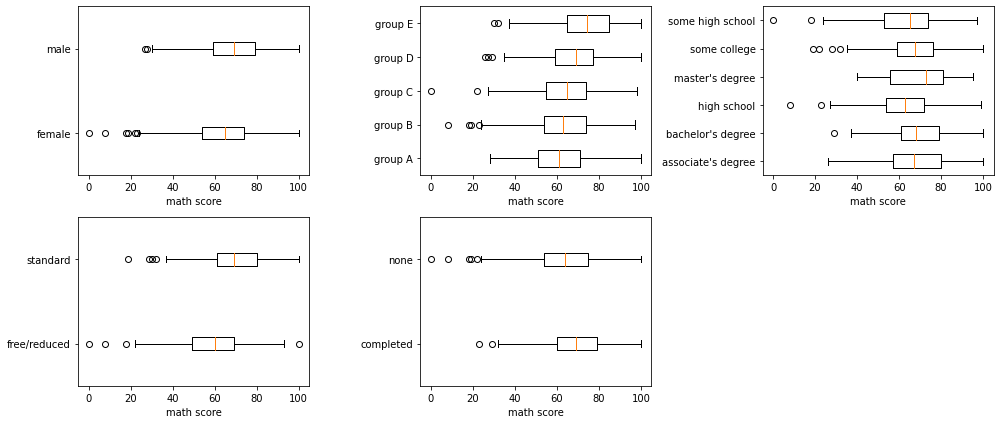

In [71]:
plt.figure(figsize = (14, 6))

for i, cat in enumerate(categorical_features, start = 1):
    categories = sorted(pd.unique(data[cat]))
    
    plt.subplot(2, 3, i)
    plt.boxplot([data.loc[data[cat] == x, 'math score'] for x in categories], labels = categories, vert = False)
    plt.xlabel('math score')

plt.tight_layout()
plt.show()

## ทดสอบความแตกต่างของค่าคะแนนสอบคณิตศาสตร์
ใช้ t-test ระหว่างกลุ่มตัวแปร **lunch**

In [36]:
standard_math = data.loc[data['lunch'] == 'standard', 'math score']
free_math = data.loc[data['lunch'] == 'free/reduced', 'math score']

print('unpaired t-test:', scipy.stats.ttest_ind(standard_math, free_math))
print('Mann-Whitney U test:', scipy.stats.mannwhitneyu(standard_math, free_math))

unpaired t-test: Ttest_indResult(statistic=11.837180472914612, pvalue=2.4131955993137074e-30)
Mann-Whitney U test: MannwhitneyuResult(statistic=161077.0, pvalue=1.522041803652298e-26)


### ทดสอบความสัมพันธ์ระหว่างเด็กที่ได้คะแนนคณิตศาสตร์สูงกับตัวแปร category ต่าง ๆ
เริ่มจากใช้ **crosstab** สร้างตารางระหว่างเด็กที่ใช้ **test preparation course** กับไม่ได้ใช้

In [37]:
prep_vs_math50 = pd.crosstab(data['test preparation course'], data['math score'] > 50)
prep_vs_math50.rename(columns = {False: '<=50', True: '>50'}, inplace = True)
prep_vs_math50.rename(index = {'completed': 'yes', 'none': 'no'}, inplace = True)
prep_vs_math50.head()

math score,<=50,>50
test preparation course,,
yes,33,325
no,117,525


ใช้ Fisher's exact test **fisher_exact** เพื่อทดสอบความสัมพันธ์ข้างบน

ตั้งค่า **alternative** เป็นอะไรดี?

In [38]:
print('two-tailed:', scipy.stats.fisher_exact(prep_vs_math50))
print('yes and math score <=50 is lower than expected:', scipy.stats.fisher_exact(prep_vs_math50, alternative = 'greater'))
print('yes and math score <=50 is higher than expected:', scipy.stats.fisher_exact(prep_vs_math50, alternative = 'less'))

two-tailed: (0.4556213017751479, 9.817463464958036e-05)
yes and math score <=50 is lower than expected: (0.4556213017751479, 0.999973362529135)
yes and math score <=50 is higher than expected: (0.4556213017751479, 6.105475694314792e-05)


### ถ้ามีหลาย category จะทำยังไง
มองแต่ละ category แยกกัน เป็น yes/no ได้ เช่น **race/erhnicity** is group A เทียบกับ **race/erhnicity** is not group A 

In [39]:
race_vs_math50 = pd.crosstab(data['race/ethnicity'], data['math score'] > 50)
race_vs_math50.rename(columns = {False: '<=50', True: '>50'}, inplace = True)
race_vs_math50.head()

math score,<=50,>50
race/ethnicity,,
group A,22,67
group B,35,155
group C,50,269
group D,31,231
group E,12,128


ใช้ Fisher's exact test ทดสอบทีละ category ของ **race/erhnicity**

In [40]:
races = sorted(pd.unique(data['race/ethnicity']))
race_vs_math_fisher = pd.DataFrame(0, index = races, columns = ['Fisher p-value', 'mininmum support'])

for race in races:
    temp_table = pd.crosstab(data['race/ethnicity'] == race, data['reading score'] > 65)
    race_vs_math_fisher.loc[race, :] = [scipy.stats.fisher_exact(temp_table)[1], temp_table.values.min()]
    
race_vs_math_fisher.head()

,Fisher p-value,mininmum support
group A,0.004225,41
group B,0.047334,87
group C,0.488151,120
group D,0.269765,95
group E,0.019363,42


## เมื่อทำการทดสอบหลายครั้ง ก็ต้องทำการ correct p-value ที่ได้
ไม่เช่นนั้น error จริงจะสูงขึ้นกว่า cutoff ที่ตั้งไว้

เริ่มจาก Bonferroni ที่ง่ายที่สุด

In [41]:
cutoff = 0.05

race_vs_math_fisher['Bonferroni'] = race_vs_math_fisher['Fisher p-value'] <= cutoff / race_vs_math_fisher.shape[0]
race_vs_math_fisher.head()

,Fisher p-value,mininmum support,Bonferroni
group A,0.004225,41,True
group B,0.047334,87,False
group C,0.488151,120,False
group D,0.269765,95,False
group E,0.019363,42,False


### อยากใช้ Benjamini-Hochberg แต่ไม่อยากเขียนโค้ดเอง
มีคนเขียนไว้แล้วใน [statsmodels](https://www.statsmodels.org/dev/index.html)

ข่าวดีคือ Google Colab ลงไว้ให้แล้ว

In [42]:
# !pip install statsmodels

ใช้ [multipletests](https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html)

In [43]:
from statsmodels.stats.multitest import multipletests

benjamini_hochberg = multipletests(race_vs_math_fisher['Fisher p-value'].values, alpha = cutoff, method = 'fdr_bh')
print(benjamini_hochberg)

(array([ True, False, False, False,  True]), array([0.02112254, 0.07888926, 0.48815061, 0.33720597, 0.04840731]), 0.010206218313011495, 0.01)


เปรียบเทียบผลระหว่าง Bonferroni กับ Benjamini-Hochberg คุ้มค่าการลงทุนเรียนรู้ library ใหม่มั้ย?

In [44]:
race_vs_math_fisher['Benjamini-Hochberg'] = benjamini_hochberg[0]
race_vs_math_fisher['FDR'] = benjamini_hochberg[1]
race_vs_math_fisher.head()

,Fisher p-value,mininmum support,Bonferroni,Benjamini-Hochberg,FDR
group A,0.004225,41,True,True,0.021123
group B,0.047334,87,False,False,0.078889
group C,0.488151,120,False,False,0.488151
group D,0.269765,95,False,False,0.337206
group E,0.019363,42,False,True,0.048407


### เวลาจะใช้ตัวแปร categorical ในโมเดลต้องทำการแปลงเป็น one-hot encoding
เช่น จากตัวแปร race/ethnicity เดียวก็แตกเป็นตัวแปร race group A, race group B, ..., race group E แยก column กัน

In [45]:
race_onehot = pd.get_dummies(data['race/ethnicity'], prefix = 'race', prefix_sep = ' ')
race_onehot.head()

,race: group A,race: group B,race: group C,race: group D,race: group E
0,0,1,0,0,0
1,0,0,1,0,0
2,0,1,0,0,0
3,1,0,0,0,0
4,0,0,1,0,0


### สำรวจความถี่ของแต่ละ category
category ที่มีความถี่ต่ำเกินไปอาจจะไม่มีประโยชน์ในการนำไปพัฒนาโมเดล

เริ่มจากการนับจำนวนข้อมูลสำหรับแต่ละ category จากทุกตัวแปร

In [46]:
sample_count = {}

for cat_feat in categorical_features:
    count = data[cat_feat].value_counts()
    sample_count.update({x: count[x] for x in count.index})

In [47]:
sample_count_df = pd.DataFrame().from_dict(sample_count, orient = 'index', columns = ['frequency'])
sample_count_df.head()

,frequency
female,518
male,482
group C,319
group D,262
group B,190


ใช้ **bar** แสดงความถี่

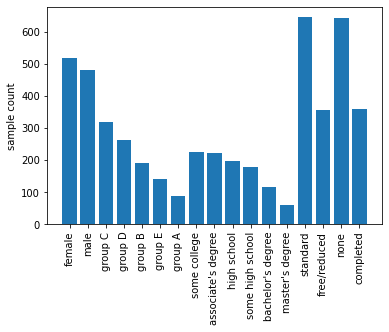

In [48]:
plt.figure()
plt.bar(range(sample_count_df.shape[0]), sample_count_df['frequency'].values)
plt.xticks(ticks = range(sample_count_df.shape[0]), labels = sample_count_df.index, rotation = 90)
plt.ylabel('sample count')
plt.show()

# ข้อมูลราคาบ้าน
เราจะจัดการ missing data และศึกษา correlation ระหว่างตัวแปรกัน

In [72]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/HousePrices.csv', index_col = 0, header = 0)
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,2-STORY 1946+,RL,65.0,8450,Pave,NaN,0,Lvl,3,Inside,...,0,0,0,NaN,0,Feb,2008,WD,Normal,208500
2,1-STORY 1946+,RL,80.0,9600,Pave,NaN,0,Lvl,3,FR2,...,0,0,0,NaN,0,May,2007,WD,Normal,181500
3,2-STORY 1946+,RL,68.0,11250,Pave,NaN,1,Lvl,3,Inside,...,0,0,0,NaN,0,Sept,2008,WD,Normal,223500
4,2-STORY 1945-,RL,60.0,9550,Pave,NaN,1,Lvl,3,Corner,...,0,0,0,NaN,0,Feb,2006,WD,Abnorml,140000
5,2-STORY 1946+,RL,84.0,14260,Pave,NaN,1,Lvl,3,FR2,...,0,0,0,NaN,0,Dec,2008,WD,Normal,250000


### ตรวจหา missing value
ใช้ **isna** ของ pandas ในการนับจำนวน missing value

นำเสนอในรูปแบบ **barh** (bar แนวนอน)

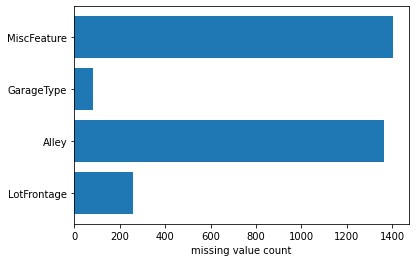

In [50]:
missing_count = pd.isna(data).sum()
with_missing = missing_count.index[missing_count > 0]

plt.figure()
plt.barh(range(len(with_missing)), missing_count[with_missing])
plt.yticks(range(len(with_missing)), labels = with_missing)
plt.xlabel('missing value count')
plt.show()

เราตัดสินใจตัดตัวแปรที่มี missing data เยอะเกินไปออก

In [51]:
filtered_data = data.drop(['MiscFeature', 'Alley'], axis = 1)

print('from', data.shape[1], 'to', filtered_data.shape[1], 'features')

from 80 to 78 features


### การเติมค่าที่หายไปด้วย imputation
เริ่มจากแบบพื้นฐานกันก่อน
* ตัวแปร category จะใช้ mode เติม
* ตัวแปร numerical จะใช้ mean หรือ median ก็ได้

In [52]:
print(filtered_data['GarageType'].dtype, pd.unique(filtered_data['GarageType']))
print(filtered_data['LotFrontage'].dtype, pd.unique(filtered_data['LotFrontage']))

object ['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']
float64 [ 65.  80.  68.  60.  84.  85.  75.  nan  51.  50.  70.  91.  72.  66.
 101.  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52.
 100.  24.  89.  63.  76.  81.  95.  69.  21.  32.  78. 121. 122.  40.
 105.  73.  77.  64.  94.  34.  90.  55.  88.  82.  71. 120. 107.  92.
 134.  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.
  93.  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.
  36.  56. 102.  58.  38. 109. 130.  53. 137.  45. 106.  42.  39. 104.
 144. 114. 128. 149. 313. 168. 182. 138. 152. 124. 153.  46.]


In [53]:
imputed_data = filtered_data.copy()
imputed_data['GarageType'] = filtered_data['GarageType'].fillna(filtered_data['GarageType'].mode())
imputed_data['LotFrontage'] = np.round(filtered_data['LotFrontage'].fillna(filtered_data['LotFrontage'].mean()))

ตรวจสอบค่าที่เติมด้วย ระวังว่าตัวแปร numerical บางตัว อาจจะเป็นจำนวนเต็ม (integer) ไม่ใช่จำนวนจริง (float)

In [54]:
print(pd.unique(imputed_data['LotFrontage']))

[ 65.  80.  68.  60.  84.  85.  75.  70.  51.  50.  91.  72.  66. 101.
  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52. 100.
  24.  89.  63.  76.  81.  95.  69.  21.  32.  78. 121. 122.  40. 105.
  73.  77.  64.  94.  34.  90.  55.  88.  82.  71. 120. 107.  92. 134.
  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.  93.
  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.  36.
  56. 102.  58.  38. 109. 130.  53. 137.  45. 106.  42.  39. 104. 144.
 114. 128. 149. 313. 168. 182. 138. 152. 124. 153.  46.]


### คำนวณ correlation ระหว่างตัวแปร numerical ทั้งหลาย
**corrcoef** ใน numpy คำนวณ Pearson's correlation ได้

In [55]:
numerical_features = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', '1stFlrSF', 'GrLivArea', 'GarageArea',
                      'WoodDeckSF', 'OpenPorchSF']

all_correlation = np.corrcoef(imputed_data[numerical_features].T)
print(all_correlation.shape)

(10, 10)


### แสดงค่า correlation ระหว่างตัวแปรด้วย heatmap 
ใน [seaborn](https://seaborn.pydata.org/generated/seaborn.heatmap.html) ในกราฟสวย ๆ สำเร็จรูปให้ใช้งาน

ข่าวดี Google Colab ก็ลงไว้แล้วเช่นกัน

In [56]:
# !pip install seaborn

import seaborn as sns

ใช้ **heatmap** แสดงโครงสร้าง correlation ระหว่างตัวแปร

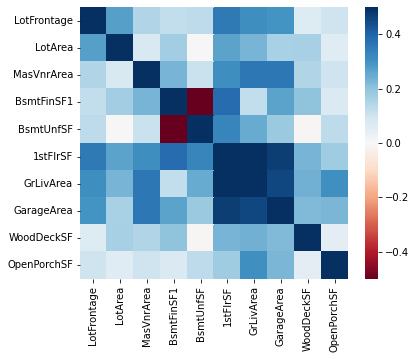

In [57]:
all_correlation = pd.DataFrame(all_correlation, index = numerical_features, columns = numerical_features)

plt.figure(figsize = (6, 5))
sns.heatmap(all_correlation, cmap = 'RdBu', center = 0, vmax = 0.5, vmin = -0.5)
plt.show()

เปลี่ยนเป็นใช้ Spearman's correlation ดูซิ

In [58]:
all_spearmanr = pd.DataFrame(0, index = numerical_features, columns = numerical_features)

for i in range(len(numerical_features)):
    all_spearmanr.iloc[i, i] = 1
    
    for j in range(i + 1, len(numerical_features)):
        all_spearmanr.iloc[i, j] = scipy.stats.spearmanr(imputed_data[numerical_features[i]], imputed_data[numerical_features[j]])[0]
        all_spearmanr.iloc[j, i] = all_spearmanr.iloc[i, j]

all_spearmanr.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,1stFlrSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF
LotFrontage,1.000000,0.560485,0.245566,0.144475,0.097357,0.384612,0.331716,0.344058,0.100033,0.152340
LotArea,0.560485,1.000000,0.171457,0.165422,0.076367,0.439520,0.444751,0.362600,0.179204,0.172116
MasVnrArea,0.245566,0.171457,1.000000,0.233517,0.071900,0.345782,0.315238,0.357794,0.170191,0.201062
BsmtFinSF1,0.144475,0.165422,0.233517,1.000000,-0.578332,0.317805,0.049578,0.238429,0.174074,0.075627
BsmtUnfSF,0.097357,0.076367,0.071900,-0.578332,1.000000,0.222719,0.252757,0.107738,-0.036694,0.155471


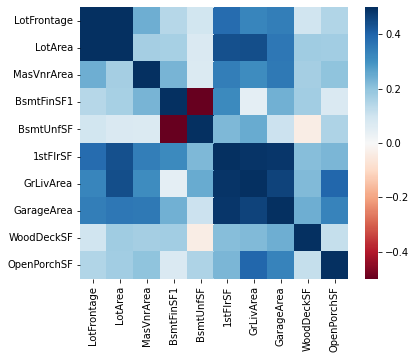

In [59]:
plt.figure(figsize = (6, 5))
sns.heatmap(all_spearmanr, cmap = 'RdBu', center = 0, vmax = 0.5, vmin = -0.5)
plt.show()

### คำนวณ correlation กับราคาขายบ้าน
เพื่อค้นหาตัวแปรที่น่าจะมีประโยชน์ในการทำนายราคาขาย

ใช้ Pearson's correlation และแสดงผลด้วย **bar**

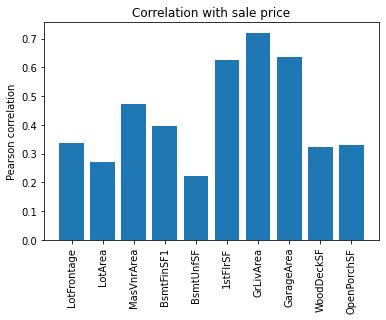

In [60]:
price_correlation = [scipy.stats.pearsonr(imputed_data['SalePrice'], imputed_data[x])[0] for x in numerical_features]

plt.figure()
plt.bar(range(len(numerical_features)), price_correlation)
plt.ylabel('Pearson correlation')
plt.xticks(range(len(numerical_features)), labels = numerical_features, rotation = 90)
plt.title('Correlation with sale price')
plt.show()

### อยากรู้ว่าค่า correlation ที่ได้ มันนิ่งแค่ไหน
ถ้ามีข้อมูลน้อยลงเหลือแค่ 40% ของทั้งหมด จะได้ correlation ค่าเดิม หรือว่าค่าจะแกว่งไปมา ขึ้นอยู่กับแต่ละส่วนของข้อมูล

ไอเดียคล้ายกับการสลับข้อมูลเพื่อคำนวณ correlation แต่คราวนี้เราไม่ได้จะสลับ แต่จะสุ่มเลือกเพียง 40% ออกมา

มีทางเลือกระหว่างคำสั่ง **random.choice** กับ **random.permutation** ใน numpy

In [73]:
np.random.seed(4649)
n_run = 100
subset_size = int(imputed_data.shape[0] * 0.4)
subset_corr = np.zeros([n_run, len(numerical_features)])

for i in range(n_run):
    indices = np.random.choice(imputed_data.index, size = subset_size, replace = False)
    subset_corr[i] = [scipy.stats.pearsonr(imputed_data['SalePrice'].loc[indices], imputed_data[x].loc[indices])[0] for x in numerical_features]

แสดงผลด้วย **bar** แบบมีขีดแสดงช่วง $\pm$1 SD 

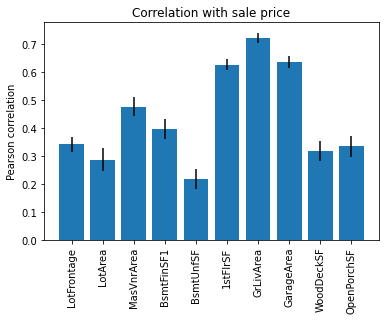

In [74]:
plt.figure()
plt.bar(range(len(numerical_features)), subset_corr.mean(axis = 0), yerr = subset_corr.std(axis = 0))
plt.ylabel('Pearson correlation')
plt.xticks(range(len(numerical_features)), labels = numerical_features, rotation = 90)
plt.title('Correlation with sale price')
plt.show()